# Section 3_1 MLP networks


## General CNN modules

In [ ]:
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn

from utils.supervised_dataset import supervised_dataset as dataset
from torch.utils.data import DataLoader
from utils.transforms import flattening_transform, reshape_transform, reindex_transform, create_cell_ind_to_grid, create_flattening_index_set,channeled_flattening_transform



class resblock(nn.Module):
    def __init__(self, layer):
        super().__init__()
        self.layer = layer

    def forward(self, x):
        z = self.layer(x)
        return z+x


from utils.transforms import cells_from_flat_array_ind

class cnn_layer(torch.nn.Module):
    def __init__(self, d, C, dim=2):
        super().__init__()
        layers = []
        for _ in range(d):
            layers.append(
                resblock(
                    torch.nn.Sequential(
                        torch.nn.Conv2d(in_channels=C,out_channels=C,kernel_size=3, padding=1,dtype=torch.float32, device='mps'),
                    torch.nn.LeakyReLU(),
                    torch.nn.BatchNorm2d(C, device='mps')
                    )
                )
            )
        self.net = torch.nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)


    
class cnn2d(torch.nn.Module):
    def __init__(self, d, w,C):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=C,out_channels=w,kernel_size=3, padding=1,dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            cnn_layer(d=d,C=w,dim=2),
            torch.nn.Conv2d(in_channels=w,out_channels=int(np.floor(w/2)),kernel_size=(69,1), padding=(34,0),dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=int(np.floor(w/2)),out_channels=int(np.floor(w/4)), kernel_size=(69,1), padding=(34,0),dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=int(np.floor(w/4)),out_channels=int(np.floor(w/8)), kernel_size=(69,1), padding=(34,0),dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=int(np.floor(w/8)),out_channels=1, kernel_size=3, padding=0,dtype=torch.float32, device='mps'),
            torch.nn.ReLU(),
        )

    def forward(self, x):
        z = self.net(x)
        return z
    

class cnn_layer_streamline(torch.nn.Module):
    def __init__(self, d, C, dim=2):
        super().__init__()
        layers = []
        for _ in range(d):
            layers.append(
                resblock(
                    torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels=C,out_channels=C,kernel_size=(69,1), padding=(34,0),dtype=torch.float32, device='mps'),
                    torch.nn.LeakyReLU(),
                    torch.nn.BatchNorm2d(C, device='mps')
                    )
                )
            )
        self.net = torch.nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)
    
class cnn2d_streamline(torch.nn.Module):
    def __init__(self, d, w,C):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=C,out_channels=w,kernel_size=(69,1), padding=(34,0),dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            cnn_layer(d=d,C=w,dim=2),
            torch.nn.Conv2d(in_channels=w,out_channels=int(np.floor(w/2)),kernel_size=(69,1), padding=(34,0),dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=int(np.floor(w/2)),out_channels=int(np.floor(w/4)), kernel_size=(69,1), padding=(34,0),dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=int(np.floor(w/4)),out_channels=int(np.floor(w/8)), kernel_size=(69,1), padding=(34,0),dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=int(np.floor(w/8)),out_channels=1, kernel_size=3, padding=0,dtype=torch.float32, device='mps'),
            torch.nn.ReLU(),
        )

    def forward(self, x):
        z = self.net(x)
        return z


## Semilocal CNN datasets and training loops

In [2]:

def train_loop(dataloader, nn, optimizer, loss_fn):
    num_batches = len(dataloader)
    nn.train()
    train_loss = 0.0
    for batch, (x, t) in enumerate(dataloader):
        y_pred = nn(x)

        loss = loss_fn(y_pred,t)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    train_loss /= num_batches
    print(f"Train loss: {train_loss:>7f}")
    return(train_loss)

def test_loop(dataloader, nn, loss_fn):
    nn.eval()
    num_batches = len(dataloader)
    test_loss = 0.0

    with torch.no_grad():
        for x, t in dataloader:
            y_pred = nn(x)

            loss = loss_fn(y_pred,t)

            test_loss += loss.item()

    test_loss /= num_batches
    print(f"Test loss: {test_loss:>8f} \n")
    return(test_loss)


def train(
        device,
        nn,
        lr,
        gamma,
        step_size,
        epochs, 
        train_set_input_dir,
        train_set_target_dir,
        test_set_input_dir,
        test_set_target_dir,
        batch_size,
        err_threshold = 1.0,
        train_loss_file = None, 
        test_loss_file = None,
        model_dir = None,
        figure = None,
        figure_file = None,
        conv_type=2,
):
    H,W = 32,32
    if conv_type == 0:
        target_transform = flattening_transform(torch.arange(H*W), 1, True)
        transform = flattening_transform(create_flattening_index_set(H+2,W+2,False),13, True)
    if conv_type == 1:
        target_transform = flattening_transform(torch.arange(H*W), 1, True)
        transform = channeled_flattening_transform(create_flattening_index_set(H+2,W+2,False),13)
    if conv_type == 2:
        target_transform = reshape_transform(H,W)
        transform = None

    train_set = dataset(
        input_dir=train_set_input_dir, 
        target_dir=train_set_target_dir, 
        transform=transform, 
        target_transform=target_transform, 
        device=device
    )

    test_set = dataset(
        input_dir=test_set_input_dir, 
        target_dir=test_set_target_dir, 
        transform=transform, 
        target_transform=target_transform, 
        device=device
    )
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=1, shuffle=True)
    
    model = nn
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=step_size, gamma=gamma)
    train_loss_array = np.array([])
    test_loss_array = np.array([])
    loss_fn = torch.nn.MSELoss()
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loss_array = np.append(
            train_loss_array, 
            train_loop(
                dataloader=train_loader,
                nn=model,
                optimizer=optimizer,
                loss_fn=loss_fn
                )
        )
        scheduler.step()
        test_loss = test_loop(
                dataloader=test_loader, 
                nn=model, 
                loss_fn=loss_fn
            )
        test_loss_array = np.append(
            test_loss_array,
            test_loss
        )
        if model_dir and test_loss < err_threshold:
            torch.save(model.state_dict(), f'{model_dir}.pth')
            err_threshold = test_loss
    if train_loss_file:
        np.save(file=train_loss_file, arr=train_loss_array)
    if test_loss_file:
        np.save(file=test_loss_file, arr=test_loss_array)
    if figure:
        clear_output()
        x= np.linspace(1,len(train_loss_array),len(train_loss_array))

        plt.plot(x, train_loss_array, label= 'Train loss', linestyle='-',)
        plt.plot(x, test_loss_array,label='Test loss', linestyle='-')

        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.grid(True)
        if figure_file:
            plt.savefig(figure_file)
        plt.show()
    return train_loss_array, test_loss_array

## Model definition

In [ ]:
w = 32
d = 5

for k in range(50):
    
    print(f"Run: {k}")
    model2d=cnn2d(d,w, 13)

    train(
        device='mps',
        nn=model2d,
        step_size=2,
        lr=0.001,
        gamma=0.5,
        epochs=30,
        train_set_input_dir = "data/example_3_1/training_set/inputs/",
        train_set_target_dir = "data/example_3_1/training_set/target_values/",
        test_set_input_dir = "data/example_3_1/test_set/inputs/",
        test_set_target_dir = "data/example_3_1/test_set/target_values/",
        batch_size=10,
        err_threshold=1.0,
        train_loss_file=f"data/example_3_2/loss_arrays/train_loss_cnn_{k}",
        test_loss_file=f"data/example_3_2/loss_arrays/test_loss_cnn_{k}",
        model_dir=f"data/example_3_2/models/cnn_{k}",
        figure=None,
        figure_file=None,
        conv_type=2
    )


    
for k in range(50):
    
    print(f"Run: {k}")
    model2d=cnn2d_streamline(d,w, 13)

    train(
        device='mps',
        nn=model2d,
        step_size=8,
        lr=0.001,
        gamma=0.5,
        epochs=30,
        train_set_input_dir = "data/example_3_1/training_set/inputs/",
        train_set_target_dir = "data/example_3_1/training_set/target_values/",
        test_set_input_dir = "data/example_3_1/test_set/inputs/",
        test_set_target_dir = "data/example_3_1/test_set/target_values/",
        batch_size=10,
        err_threshold=1.0,
        train_loss_file=f"data/example_3_2/loss_arrays/train_loss_cnn_streamline_{k}",
        test_loss_file=f"data/example_3_2/loss_arrays/test_loss_cnn_streamline_{k}",
        model_dir=f"data/example_3_2/models/cnn_streamline_{k}",
        figure=None,
        figure_file=None,
        conv_type=2
    )


    print(f"Run: {k}")
    model2d=cnn2d(d,w, 16)

    train(
        device='mps',
        nn=model2d,
        step_size=8,
        lr=0.001,
        gamma=0.5,
        epochs=30,
        train_set_input_dir = "data/example_3_2/training_set/inputs/",
        train_set_target_dir = "data/example_3_1/training_set/target_values/",
        test_set_input_dir = "data/example_3_2/test_set/inputs/",
        test_set_target_dir = "data/example_3_1/test_set/target_values/",
        batch_size=10,
        err_threshold=1.0,
        train_loss_file=f"data/example_3_2/loss_arrays/train_loss_cnn_pre_{k}",
        test_loss_file=f"data/example_3_2/loss_arrays/test_loss_cnn_pre_{k}",
        model_dir=f"data/example_3_2/models/cnn_pre_{k}",
        figure=None,
        figure_file=None,
        conv_type=2
    )



Run: 0
Epoch 1
-------------------------------
Train loss: 0.165270
Test loss: 0.048942 

Epoch 2
-------------------------------
Train loss: 0.020913
Test loss: 0.012929 

Epoch 3
-------------------------------
Train loss: 0.007109
Test loss: 0.003121 

Epoch 4
-------------------------------
Train loss: 0.004284
Test loss: 0.002318 

Epoch 5
-------------------------------
Train loss: 0.003223
Test loss: 0.001770 

Epoch 6
-------------------------------
Train loss: 0.002589
Test loss: 0.001630 

Epoch 7
-------------------------------
Train loss: 0.002492
Test loss: 0.001397 

Epoch 8
-------------------------------
Train loss: 0.002293
Test loss: 0.001336 

Epoch 9
-------------------------------
Train loss: 0.002066
Test loss: 0.001220 

Epoch 10
-------------------------------
Train loss: 0.001839
Test loss: 0.001233 

Epoch 11
-------------------------------
Train loss: 0.002159
Test loss: 0.001184 

Epoch 12
-------------------------------
Train loss: 0.001889
Test loss: 0.001

In [27]:
for k in range(50):
    


    print(f"Run: {k}")

    train(
        device='mps',
        nn=model2d,
        step_size=8,
        lr=0.001,
        gamma=0.5,
        epochs=30,
        train_set_input_dir = "data/example_3_2/training_set/inputs/",
        train_set_target_dir = "data/example_3_1/training_set/target_values/",
        test_set_input_dir = "data/example_3_2/test_set/inputs/",
        test_set_target_dir = "data/example_3_1/test_set/target_values/",
        batch_size=10,
        err_threshold=1.0,
        train_loss_file=f"data/example_3_2/loss_arrays/train_loss_cnn_pre_{k}",
        test_loss_file=f"data/example_3_2/loss_arrays/test_loss_cnn_pre_{k}",
        model_dir=f"data/example_3_2/models/cnn_pre_{k}",
        figure=None,
        figure_file=None,
        conv_type=2
    )

Run: 0
Epoch 1
-------------------------------
Train loss: 0.024532
Test loss: 0.002988 

Epoch 2
-------------------------------
Train loss: 0.004529
Test loss: 0.004355 

Epoch 3
-------------------------------
Train loss: 0.004042
Test loss: 0.003548 

Epoch 4
-------------------------------
Train loss: 0.003265
Test loss: 0.001888 

Epoch 5
-------------------------------
Train loss: 0.002511
Test loss: 0.001426 

Epoch 6
-------------------------------
Train loss: 0.002096
Test loss: 0.003145 

Epoch 7
-------------------------------
Train loss: 0.002325
Test loss: 0.000859 

Epoch 8
-------------------------------
Train loss: 0.001616
Test loss: 0.000941 

Epoch 9
-------------------------------
Train loss: 0.001377
Test loss: 0.002234 

Epoch 10
-------------------------------
Train loss: 0.001425
Test loss: 0.000752 

Epoch 11
-------------------------------
Train loss: 0.001159
Test loss: 0.000830 

Epoch 12
-------------------------------
Train loss: 0.001065
Test loss: 0.000

In [22]:
w = 32
d = 5
print(f"Parameters CNN_S: \t{sum(p.numel() for p in cnn2d_streamline(d,w, 13).parameters())}")


print(f"Parameters CNN: \t{sum(p.numel() for p in cnn2d(d,w, 13).parameters())}")


print(f"Parameters CNN_pre: \t{sum(p.numel() for p in cnn2d(d,w, 16).parameters())}")

Parameters CNN_S: 	56449
Parameters CNN: 	96769
Parameters CNN_pre: 	97633


## Visualization of the loss values

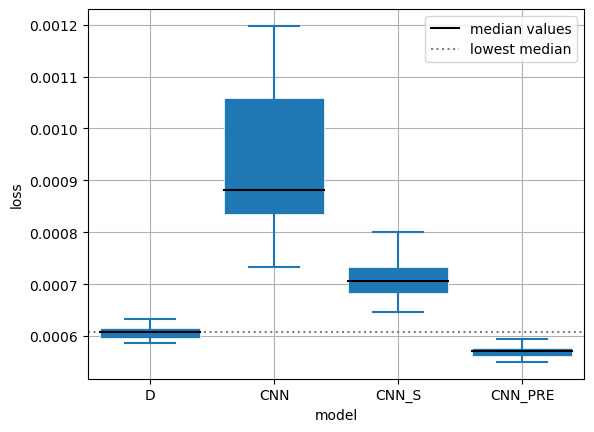

In [28]:
import numpy as np
import matplotlib.pyplot as plt
step = 50
dir0 = "data/example_3_1/loss_arrays/test_cMLP_10hidden"
dir1 = "data/example_3_2/loss_arrays/test_loss_cnn"
dir2 = "data/example_3_2/loss_arrays/test_loss_cnn_pre"
dir3 = "data/example_3_2/loss_arrays/test_loss_cnn_streamline"



def load_loss_arrays(dir, idx, threshold=None):
    l = []
    for k in idx:
        arr = np.load(f"{dir}_{k}.npy")
        if threshold:
            if np.max(arr) < threshold:
                l.append(arr)
        else:
            l.append(arr)
    return np.stack(l, axis = 0)
x = ['D', 'CNN', 'CNN_S', 'CNN_PRE']
boxMLP = load_loss_arrays(dir0, np.arange(step), None)
boxcnn = load_loss_arrays(dir1, np.arange(step), None)
boxcnn_pre = load_loss_arrays(dir2, np.arange(step), None)
boxcnn_st = load_loss_arrays(dir3, np.arange(step), None)
boxavg = np.vstack(
    [
        np.min(boxMLP, axis=1),
        np.min(boxcnn, axis=1),
        np.min(boxcnn_st, axis=1),
        np.min(boxcnn_pre, axis=1)
        ]
    )
bp = plt.boxplot(
    boxavg.T, 
    labels=x, 
    widths=0.8, 
    patch_artist=True, 
    #meanline=True,
    showfliers=False,
    meanprops={'marker':'o', "markerfacecolor":"yellow", "color":"yellow","markeredgecolor":"black"},
    medianprops={"color": "black", "linewidth": 1.5},
    boxprops={"facecolor": "C0", "edgecolor": "white",
                "linewidth": 0.5},
    whiskerprops={"color": "C0", "linewidth": 1.5},
    capprops={"color": "C0", "linewidth": 1.5}
)
lower_whisker_y = bp['whiskers'][0].get_ydata()[1]
lower_median = bp['medians'][0].get_ydata()[0]
bp['medians'][0].set_label('median values')

#plt.axhline(lower_whisker_y, linestyle='--', linewidth=1, color='green', label='best overall')
plt.axhline(lower_median, linestyle=':', linewidth=1.5, color='grey', label='lowest median')




#plt.ylim(0.0005,0.00415)
plt.legend()
plt.grid()
plt.xlabel('model')
plt.ylabel('loss')
plt.savefig('example_3_2_loss_boxplot.png')
plt.show()

# Reconstruct fem solver from input

In [1]:
from dolfinx import mesh as msh
from mpi4py import MPI
from utils.transforms import channeled_flattening_transform, create_flattening_index_set
from utils.supervised_dataset import supervised_dataset as dataset
import torch

from utils.transforms import reshape_transform

from utils.plotter import fem_plotter_grid


nx , ny = 32,32
reshape = reshape_transform(32,32)

def x_to_mesh(x, dofmap, ufl_domain, comm):
    VtoC_fmap = torch.tensor(dofmap).flatten()
    x = x[:8,1:-1,1:-1]
    
    #h,w = 
    cellvs = channeled_flattening_transform(flat_key=create_flattening_index_set(nx,ny,continuous_traversal=False),C=8)(x[:8])
    cellvs.T[0].reshape(-1,2)
    pts = []
    for vs in cellvs.T:
        pts.append(vs.reshape(-1,2))
    pts = torch.concat((pts))
    idx = torch.arange(torch.max(VtoC_fmap)+1)
    for j in range(len(idx)):
        idx[j] = torch.where(VtoC_fmap==j)[0][0]

    retval = torch.zeros((len(idx),3))
    retval[:,0:2] = pts[idx]
    return msh.create_mesh(comm=comm, cells=dofmap, x=retval.detach().numpy(),e=ufl_domain)



from dolfinx import mesh as msh
from mpi4py import MPI
from dolfinx import fem
from dolfinx import default_scalar_type
import ufl
import numpy as np
import torch
from utils.FEniCSx_solver import FEniCSx_solver

x = torch.load('data/example_3_1/training_set/inputs/x_1.pt')

def x_to_fem_data(x_tensor, dofmap, ufl_domain, comm):
    domain = x_to_mesh(x_tensor, dofmap, ufl_domain, comm)
    Wh = fem.functionspace(domain, ('P', 2))
    domain.topology.create_connectivity(domain.topology.dim - 1, domain.topology.dim)
    boundary_facets = msh.exterior_facet_indices(domain.topology)
    boundary_dofs = fem.locate_dofs_topological(Wh, domain.topology.dim-1, boundary_facets)
    eps = fem.Constant(domain, default_scalar_type(1e-8))
    c = fem.Constant(domain, default_scalar_type(0.0))
    f = fem.Constant(domain, default_scalar_type(1.0))
    bK = x_tensor[9:11, 1,1]
    if torch.allclose(bK, torch.tensor([ 1.0, 0.0], dtype = bK.dtype)):
        b = ufl.as_vector((fem.Constant(domain, default_scalar_type(1.0)),fem.Constant(domain, default_scalar_type(0.0))))
        dir = 0

    if torch.allclose(bK, torch.tensor([ -1.0, 0.0], dtype = bK.dtype)):
        b = ufl.as_vector((fem.Constant(domain, default_scalar_type(-1.0)),fem.Constant(domain, default_scalar_type(0.0))))
        dir = 0

    if torch.allclose(bK, torch.tensor([ 0.0, 1.0], dtype = bK.dtype)):
        b = ufl.as_vector((fem.Constant(domain, default_scalar_type(0.0)),fem.Constant(domain, default_scalar_type(1.0))))
        dir = 1

    if torch.allclose(bK, torch.tensor([ 0.0, -1.0], dtype = bK.dtype)):
        b = ufl.as_vector((fem.Constant(domain, default_scalar_type(0.0)),fem.Constant(domain, default_scalar_type(-1.0))))
        dir = 1

    x = ufl.SpatialCoordinate(domain)
    


    uD = torch.concat((x_tensor[12,0,:],x_tensor[12,-1,:],x_tensor[12,:,0],x_tensor[12,:,-1]))
    if torch.max(uD)>0.1:
        ex_exp = x[dir]
        if torch.min(bK) < 0:
            ex_exp = 1 - ex_exp
        uh = fem.Function(Wh)
            
        exp = fem.Expression(ex_exp, Wh.element.interpolation_points())

        u_ex = fem.Function(Wh)
        u_ex.interpolate(exp)
        bcs = [fem.dirichletbc(u_ex, boundary_dofs)]
    else:
        ex_exp = x[dir]*(1-ufl.exp(-(1-x[dir])/eps))* (1 - (((ufl.exp(-(1-x[(dir+1)%2])/eps)  + ufl.exp(-(x[(dir+1)%2])/eps)))- ufl.exp(-(1)/eps))/(1-ufl.exp(-1/eps)))

        if torch.min(bK) < 0:
            ex_exp = (1-x[dir])*(1-ufl.exp(-(x[dir])/eps))* (1 - (((ufl.exp(-(1-x[(dir+1)%2])/eps)  + ufl.exp(-(x[(dir+1)%2])/eps)))- ufl.exp(-(1)/eps))/(1-ufl.exp(-1/eps)))
    
        uh = fem.Function(Wh)
            
        exp = fem.Expression(ex_exp, Wh.element.interpolation_points())

        u_ex = fem.Function(Wh)
        u_ex.interpolate(exp)
        bcs = [fem.dirichletbc(fem.Constant(domain, default_scalar_type(0.0)), boundary_dofs, Wh)]

    loss = (uh-u_ex)**2 * ufl.dx
    pde_data = domain,Wh,uh,eps,b,c,f,None,bcs
    fs = FEniCSx_solver(pde_data=pde_data, loss_form=loss)

    norm_b = ufl.sqrt(ufl.dot(b,b))
    h = ufl.CellDiameter(domain=domain) 
    alpha = norm_b*h/(2*eps)
    Xi = (1/ufl.tanh(alpha)-1/alpha)
    tau_K = h/(2*norm_b)*Xi
    Yh = fem.functionspace(domain, ('DG', 0))
    yh = fem.Function(Yh)
    yh_exp = fem.Expression(tau_K, Yh.element.interpolation_points())
    yh.interpolate(yh_exp)
    fs.set_weights(yh.x.array)
    return fs


In [29]:


test_set_input_dir = "data/example_3_1/training_set/inputs/"
test_set_target_dir = "data/example_3_1/training_set/target_values/"
test_set = dataset(input_dir=test_set_input_dir, target_dir=test_set_target_dir, transform=None, target_transform=None)
for idx in range(len(test_set)):
    x,_ = test_set[idx]
    mesh = msh.create_unit_square(MPI.COMM_WORLD, nx, ny, msh.CellType.quadrilateral)
    dofmap = mesh.geometry.dofmap
    ufl_domain = mesh.ufl_domain()
    comm = MPI.COMM_WORLD
    fs = x_to_fem_data(x, dofmap=dofmap, ufl_domain=ufl_domain, comm=comm)
    yh = fs.yh.x.array

    yh = torch.nn.functional.pad(torch.tensor(reshape(yh), dtype=torch.float32), pad=(1,1,1,1))
    u,v = ufl.TrialFunction(fs.yh.function_space), ufl.TestFunction(fs.yh.function_space)
    uh = fs.uh
    a = ufl.inner(u, v) * ufl.dx
    L = ufl.inner(uh, v) * ufl.dx


    loss = fs.loss_form
    for integral in loss.integrals():
        integrand = integral.integrand()
        loss = ufl.replace(loss, {integrand: integrand * v})
    loc_loss = fem.assemble_vector(fem.form(loss)).array

    loc_loss = torch.nn.functional.pad(torch.tensor(reshape(loc_loss), dtype=torch.float32), pad=(1,1,1,1))

    problem = fem.petsc.LinearProblem(
        a, L,
        petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
    )

    uh = problem.solve().x.array
    uh = torch.nn.functional.pad(torch.tensor(reshape(uh), dtype=torch.float32), pad=(1,1,1,1))

    addon = torch.concat((uh,yh,loc_loss), dim = 0)
    x = torch.concat((x,addon), dim= 0)

    torch.save(x, f'data/example_3_2/training_set/inputs/x_{idx}.pt')

In [12]:
#fs.set_weights(t.detach().numpy())
grid = fem_plotter_grid(fs.uh.function_space)
grid.add_data(loc_loss)
import pyvista as pv

p = pv.Plotter()
p.camera_position = 'xy'

p.add_mesh(grid.grid, show_edges=True)
p.reset_camera()
p.show()


Widget(value='<iframe src="http://localhost:53967/index.html?ui=P_0x320a69550_0&reconnect=auto" class="pyvista…

In [73]:
from IPython.display import clear_output
loss_arr = []
for i in range(len(test_set)):
    x,t = test_set[i]
    fs = x_to_fem_data(x, dofmap, ufl_domain, comm)
    fs.set_weights(t.detach().numpy())
    loss_arr.append(fs.loss())
    
    #print(f"Nr. {i}: loss: {loss_arr[-1]}")
loss_arr = np.array(loss_arr)
x = np.linspace(0,len(loss_arr), len(loss_arr))

print(f"test loss: {np.average(loss_arr)}")

AttributeError: 'tuple' object has no attribute 'set_weights'

In [ ]:
from utils.reassing_dtypes import reassign_dtypes

reassign_dtypes(test_set, torch.float32)

In [18]:

test_set_input_dir = "data/example_3_2/training_set/inputs/"
test_set_target_dir = "data/example_3_1/training_set/target_values/"
test_set = dataset(input_dir=test_set_input_dir, target_dir=test_set_target_dir, transform=None, target_transform=None)
x,t = test_set[0]
x.shape

torch.Size([13, 34, 34])